In [1]:
import numpy as np
import sys
import os
import netCDF4 as nc
import bisect
import argparse
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
%matplotlib inline

def nearest_index(array, value):
    """returns index in array of nearest value in O(log n)"""
    y = bisect.bisect(array, value)
    if (y == len(array)) or (abs(array[y-1] - value) < abs(array[y] - value)):
        return y-1
    else:
        return y

#setting size for output figures 
fig_size = [12, 9]
plt.rcParams["figure.figsize"] = fig_size

# Outline

This intent of this document is to explain the process of regridding North-East convention B-grid surface velocity fields to a South-West convention C-grid. The particular application we have in mind is regridding MOM5 output for use with the MITGCM. We first construct a C-grid from the B-grid, then regrid the velocity fields, and conclude by comparing the land/sea boundary on the B-grid and the constructed C-grid. 

# The Grids 

Regridding involves interpolating to find the velocities at C grid points using the known data from B grid points. The schematic below illustrates the the difference between the two grids:

<img src="files/regrid_schematic.png">

The structure of the CM2.6/MOM5 grid changes at 65 N. South of 65 N the grid is quasi-mercator and north of 65 N it is a Murray tripolar grid. Regridding from a Murray tripolar B-grid to a quasi-mercator C-grid is beyond the scope of our project: we limit our domain to the data south of 65 N. In our domain, the grid is quasimercator, from which it follows that a `u_C` point is in general not equidistant from the `u_B` point above it and the `u_B` point beneath it.

First, we load in the grid data for the CM2.6 B-grid:

In [2]:
half_len_data = nc.Dataset('CM2p6_half_len.nc')

Now we will load in the tracer cell latitude and longitude from this dataset. We remove the latitude points north of 65, so that `lon_T` and `lat_T` are the longitude arrays and latitude arrays respectively of points just in our trimmed domain. 

In [3]:
grid_y_T = half_len_data['grid_y_T'][...]
lon_T = half_len_data['grid_x_T'][...]
cutoff_value_T = 65.0
cutoff_index_T = nearest_index(grid_y_T[:], cutoff_value_T)-1 
lat_max_index = np.shape(grid_y_T)[0]
lat_T = np.delete(grid_y_T, range(cutoff_index_T, lat_max_index))  # removes polar region

Next we load in the B-grid U velocity longitudes and latitudes from a file that contains the  daily surface field. We then remove the polar region from the U grid. 

In [4]:
vel_data = nc.Dataset('surf_vel_sample.nc')
lat_U = vel_data['yu_ocean'][...]
lon_U = vel_data['xu_ocean'][...]

In [5]:
cutoff_value_U = 65.0
cutoff_index_U = nearest_index(lat_U[:], cutoff_value_U)
lat_U = np.delete(lat_U, range(cutoff_index_U, np.shape(lat_U)[0]) )  # removes polar region

To visualize the grids, I find it helpful to create "grid matrices" of the form: `T_grid[i,j,:] = [lon_T[i], lat_T[j]]`

In [6]:
T_grid = np.zeros((np.shape(lon_T)[0] ,np.shape(lat_T)[0], 2))
B_grid = np.zeros((np.shape(lon_U)[0] ,np.shape(lat_U)[0], 2))
for i in range(len(lon_T)):
    for j in range(len(lat_T)):
        T_grid[i,j,0] = lon_T[i]
        T_grid[i,j,1] = lat_T[j]
for i in range(len(lon_U)):
    for j in range(len(lat_U)):
        B_grid[i,j,0] = lon_U[i]
        B_grid[i,j,1] = lat_U[j]

We can then easily verify the grid structure by plotting a portion of the grid:

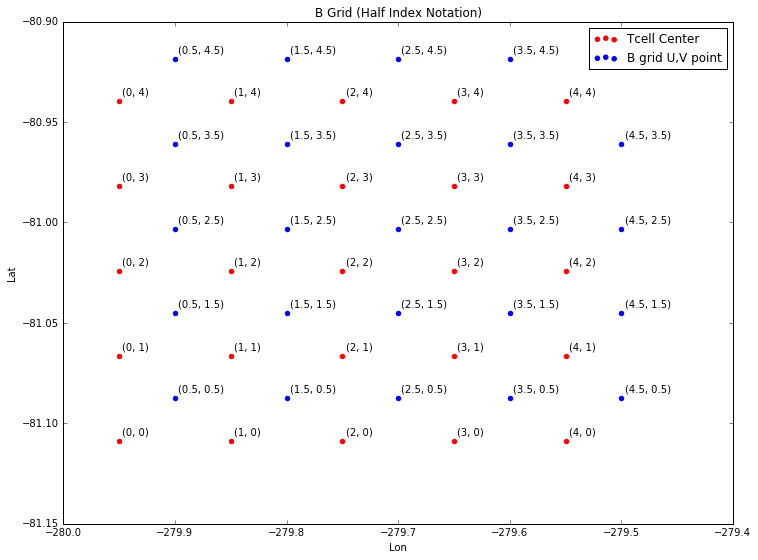

In [7]:
plt.scatter(T_grid[0:5,0:5,0].flatten(), T_grid[0:5,0:5,1].flatten(), color ='red', label='Tcell Center')
plt.scatter(B_grid[0:5,0:5,0].flatten(), B_grid[0:5,0:5,1].flatten(), color ='blue', label='B grid U,V point')

for i in range(0,5):
    for j in range(0,5):
        plt.annotate((i,j),(T_grid[i,j,0]+.003,T_grid[i,j,1]+.003))
        plt.annotate((i+.5,j+.5),(B_grid[i,j,0]+.003, B_grid[i,j,1]+.003))
        
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.legend()
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.title("B Grid (Half Index Notation)" )
plt.show()

# Building the C-grid

We construct the C-grid from the B-grid. To do this, I think it is most helpful to view the grid not in half-index notation, but in the native indices of the matrices themselves: 

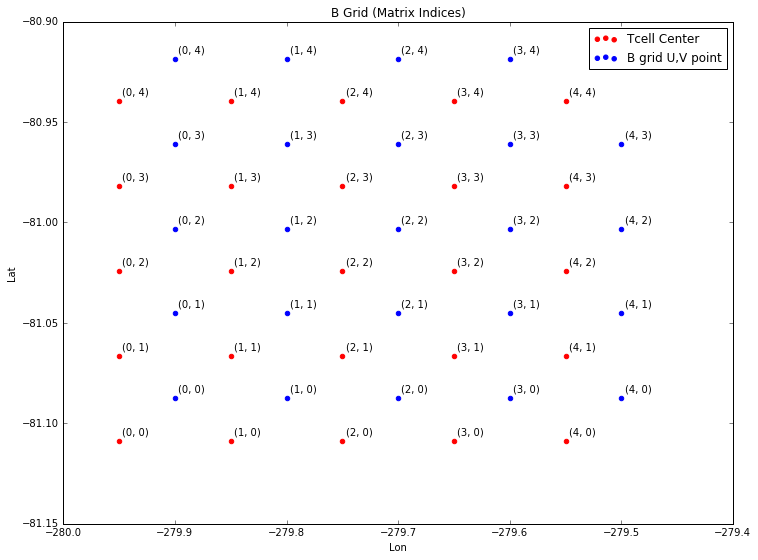

In [8]:
plt.scatter(T_grid[0:5,0:5,0].flatten(), T_grid[0:5,0:5,1].flatten(), color ='red', label='Tcell Center')
plt.scatter(B_grid[0:5,0:5,0].flatten(), B_grid[0:5,0:5,1].flatten(), color ='blue', label='B grid U,V point')

for i in range(0,5):
    for j in range(0,5):
        plt.annotate((i,j),(T_grid[i,j,0]+.003,T_grid[i,j,1]+.003))
        plt.annotate((i,j),(B_grid[i,j,0]+.003, B_grid[i,j,1]+.003))
        
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.legend()
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.title("B Grid (Matrix Indices)" )
plt.show()

The above plot helps me get the indexing correct when we construct the C grid U and V matrices:

In [9]:
C_grid_U = np.zeros((np.shape(lon_U)[0] ,np.shape(lat_U)[0], 2))
C_grid_V = np.zeros((np.shape(lon_U)[0] ,np.shape(lat_U)[0], 2))

# creates all C grid U points 
for i in range(len(lon_U)):
    for j in range(len(lat_U)):
        C_grid_U[i,j,0] = lon_U[i-1] 
        C_grid_U[i,j,1] = lat_T[j]
        
#creates C grid V points everywhere above the southernmost Tcell row  
for i in range(len(lon_U)):
    for j in range(1,len(lat_U)):
        C_grid_V[i,j,0] = lon_T[i] 
        C_grid_V[i,j,1] = lat_U[j-1]
        
#adds in a row of C grid V points beneath the existing Tcell row 
for i in range(len(lon_U)):
    C_grid_V[i,0,0] = lon_T[i]
    C_grid_V[i,0,1] = lat_U[0] + (lat_U[0] - lat_U[1])


To verify, lets plot the result: 

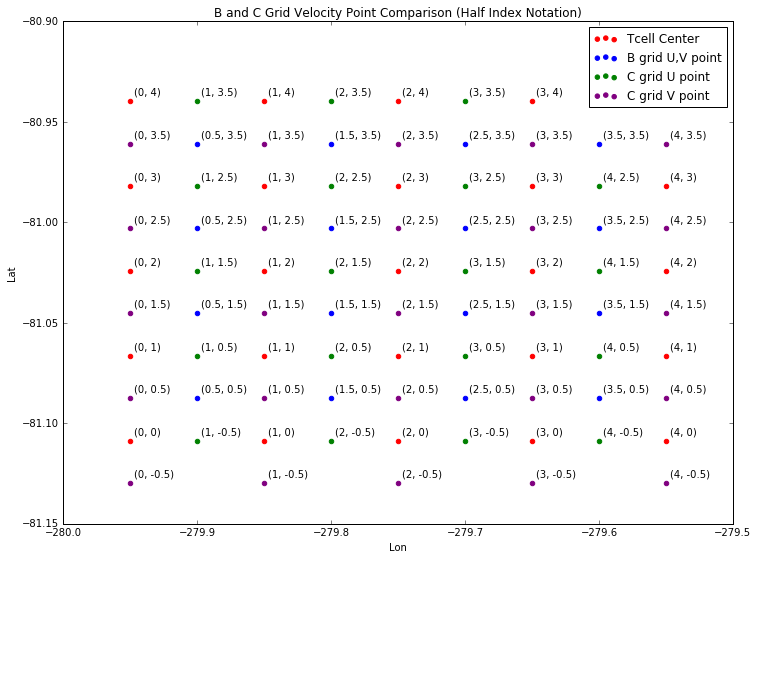

In [10]:
plt.scatter( T_grid[0:5,0:5,0].flatten(), T_grid[0:5,0:5,1].flatten(), color ='red', label='Tcell Center')
plt.scatter( B_grid[0:4,0:4,0].flatten(), B_grid[0:4,0:4,1].flatten(), color ='blue', label='B grid U,V point')
plt.scatter( C_grid_U[1:5,0:5,0].flatten(), C_grid_U[1:5,0:5,1].flatten(), color ='green', label='C grid U point')
plt.scatter( C_grid_V[0:5,0:5,0].flatten(), C_grid_V[0:5,0:5,1].flatten(), color ='purple', label='C grid V point')
for i in range(0,5):
    for j in range(0,5):
        plt.annotate((i,j),(T_grid[i,j,0]+.003,T_grid[i,j,1]+.003))
        plt.annotate((i,j-.5),(C_grid_U[i,j,0]+.003,C_grid_U[i,j,1]+.003))
        plt.annotate((i,j-.5),(C_grid_V[i,j,0]+.003,C_grid_V[i,j,1]+.003))
for i in range(0,4):
    for j in range(0,4):        
        plt.annotate((i+.5,j+.5),(B_grid[i,j,0]+.003, B_grid[i,j,1]+.003) )
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.legend()
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.title("B and C Grid Velocity Point Comparison (Half Index Notation)" )
plt.show()

This plot reveals that to interpolate from a NE convention B grid to a SW convention C grid, one cannot interpolate to find the C grid velocities for the southernmost latitude row.
On this bottom latitude row, we do not have the necessary B grid velocities (in blue) to interpolate to find the C grid V velocities (in purple). 

Since this bottom latitude row in our model is land (Antartica), even though the B grid points do not exist south of -81.12, we know that any velocities independent of the grid choice must be zero. Therefore, our low-cost solution is to include the bottom latitude row in the C grid, but set all the corresponding C grid V velocities to zero. 

In order to find the interpolation formula, I think it is helpful once again to work in the native indices of the matrices:  

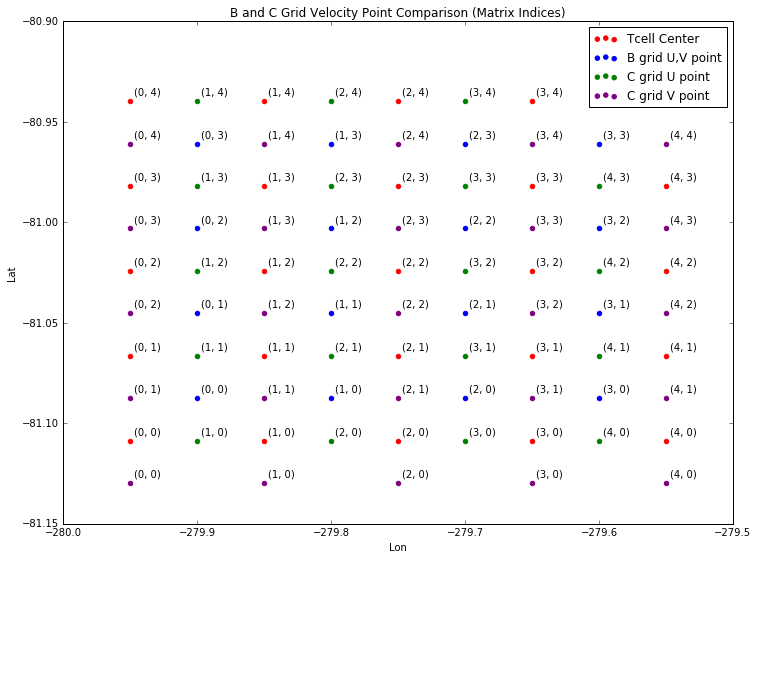

In [11]:
plt.scatter( T_grid[0:5,0:5,0].flatten(), T_grid[0:5,0:5,1].flatten(), color ='red', label='Tcell Center')
plt.scatter( B_grid[0:4,0:4,0].flatten(), B_grid[0:4,0:4,1].flatten(), color ='blue', label='B grid U,V point')
plt.scatter( C_grid_U[1:5,0:5,0].flatten(), C_grid_U[1:5,0:5,1].flatten(), color ='green', label='C grid U point')
plt.scatter( C_grid_V[0:5,0:5,0].flatten(), C_grid_V[0:5,0:5,1].flatten(), color ='purple', label='C grid V point')
for i in range(0,5):
    for j in range(0,5):
        plt.annotate((i,j),(T_grid[i,j,0]+.003,T_grid[i,j,1]+.003))
        plt.annotate((i,j),(C_grid_U[i,j,0]+.003,C_grid_U[i,j,1]+.003))
        plt.annotate((i,j),(C_grid_V[i,j,0]+.003,C_grid_V[i,j,1]+.003))
for i in range(0,4):
    for j in range(0,4):        
        plt.annotate((i,j),(B_grid[i,j,0]+.003, B_grid[i,j,1]+.003) )
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.legend()
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.title("B and C Grid Velocity Point Comparison (Matrix Indices)" )
plt.show()

# The Interpolation Step

This reveals that for the C grid V velocities, our averaging scheme using the matrix indices should be  

                    v_C[i,j] = (v_B[i-1,j-1] + v_B[i,j-1])/2
If our meridional spacing were uniform, we could also simply average to find

                    u_C[i,j] = (u_B[i-1,j] + u_B[i-1,j-1])/2
                    
However, since our grid is quasi-mercator, we weight the average with the distance factors.

`du_Eface_N` : the distance in (m) from the tracer cell east face center to the North-East corner 

`du_Eface_S` : the distance in (m) from the Tracer cell east face center to the South-West corner 

The weighted average is then given by 

                du_Eface_N[i-1,j]u_B[i-1,j] + du_Eface_S[i-1,j]u_B[i-1,j-1]
    u_C[i,j] = ___________________________________________________________________
                         du_Eface_N[i,j-1] + du_Eface_S[i,j-1]




We now load in the velocity and face half-length data. With the velocities we must switch from the CM2.6 indexing scheme of (lat, lon) to match MITGCM indexing of (lon, lat). For the interpolation, we want the masked points to have zero velocity, so we replace the existing fillvalue of -1e20 with 0.0 in the masked arrays:

In [12]:
u_B = vel_data['usurf'][0,0:cutoff_index_U,:] #omits polar region
v_B = vel_data['vsurf'][0,0:cutoff_index_U,:] #omits polar region 
u_B = np.transpose(u_B) # convert CM2.6 output from (lat, lon) indexing to (lon, lat) 
v_B = np.transpose(v_B) # convert CM2.6 output from (lat, lon) indexing to (lon, lat)

u_B = ma.filled(u_B, fill_value=0.0) #change fill value from -1e20 to 0.0 
v_B = ma.filled(v_B, fill_value=0.0) #change fill value from -1e20 to 0.0 

du_Eface_N = half_len_data['ds_21_22_T'][0:cutoff_index_T, :] #omits polar region
du_Eface_S = half_len_data['ds_20_21_T'][0:cutoff_index_T, :] #omits polar region 

# convert CM2.6 output from (lat, lon) indexing to (lon, lat) 
du_Eface_N = np.transpose(du_Eface_N) 
du_Eface_S = np.transpose(du_Eface_S) 

In [13]:
u_C = np.zeros(np.shape(u_B))
v_C = np.zeros(np.shape(v_B))

Now we compute the interpolation. Note that the interpolation for `u_C` does not solve for the velocities on the southernmost latitude row, which remain zero (since Antartica) as discussed earlier:

In [14]:
LON_POINTS = np.shape(u_C)[0]
LAT_POINTS = np.shape(u_C)[1] 

for i in range(LON_POINTS):
    for j in range(LAT_POINTS):
        v_C[i,j] = (v_B[i-1, j-1] + v_B[i, j-1])/2
        
for i in range(LON_POINTS):
    for j in range(1,LAT_POINTS):
        u_C[i,j] = ( (du_Eface_N[i-1, j]*u_B[i-1, j] + du_Eface_S[i-1, j]*u_B[i-1, j-1]) \
                    /(du_Eface_N[i, j-1] + du_Eface_S[i, j-1] ) )                    

To help verify, we can plot out the velocities on a grid face:

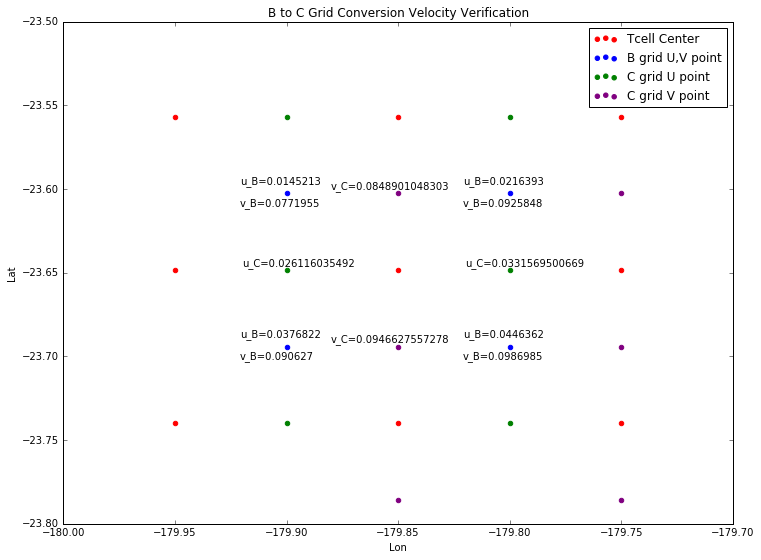

In [15]:
Lbound = 1000
Hbound = 1003
plt.scatter( T_grid[Lbound:Hbound,Lbound:Hbound,0].flatten(), T_grid[Lbound:Hbound,Lbound:Hbound,1].flatten(), color ='red', label='Tcell Center')
plt.scatter( B_grid[Lbound:Hbound-1,Lbound:Hbound-1,0].flatten(), B_grid[Lbound:Hbound-1,Lbound:Hbound-1,1].flatten(), color ='blue', label='B grid U,V point')
plt.scatter( C_grid_U[Lbound+1:Hbound,Lbound:Hbound,0].flatten(), C_grid_U[Lbound+1:Hbound,Lbound:Hbound,1].flatten(), color ='green', label='C grid U point')
plt.scatter( C_grid_V[Lbound+1:Hbound,Lbound:Hbound,0].flatten(), C_grid_V[Lbound+1:Hbound,Lbound:Hbound,1].flatten(), color ='purple', label='C grid V point')

for i in range(Lbound+1, Hbound):
    for j in range(Lbound+1,Hbound-1):
        plt.annotate("u_C="+str(u_C[i,j]),(C_grid_U[i,j,0]-.02,C_grid_U[i,j,1]+.003) )
        
for i in range(Lbound+1, Hbound-1):
    for j in range(Lbound+1,Hbound):        
        plt.annotate("v_C="+str(v_C[i,j]),(C_grid_V[i,j,0]-.03,C_grid_V[i,j,1]+.003) )
        
for i in range(Lbound,Hbound-1):
    for j in range(Lbound,Hbound-1):        
        plt.annotate("u_B="+str(u_B[i,j]),(B_grid[i,j,0]-.021, B_grid[i,j,1]+.006) )
        plt.annotate("v_B="+str(v_B[i,j]),(B_grid[i,j,0]-.021, B_grid[i,j,1]-.007) )
        
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.legend()
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.title("B to C Grid Conversion Velocity Verification" )
plt.show()

Here is another sample grid face:

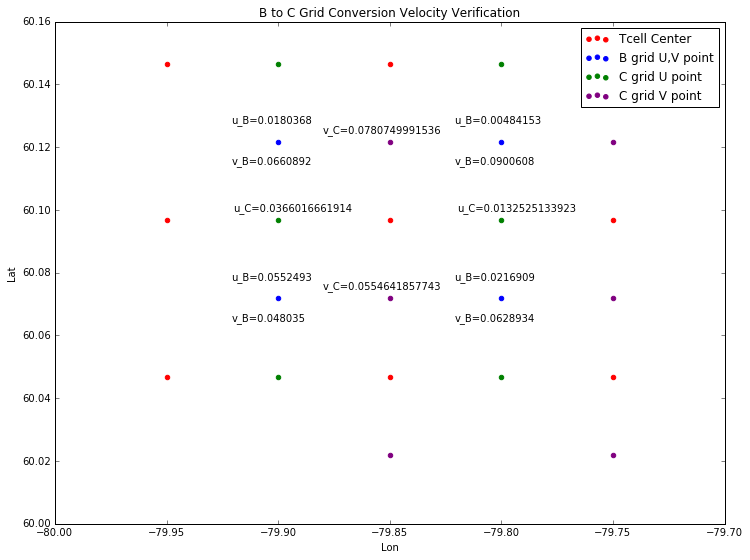

In [16]:
Lbound = 2000
Hbound = 2003
plt.scatter( T_grid[Lbound:Hbound,Lbound:Hbound,0].flatten(), T_grid[Lbound:Hbound,Lbound:Hbound,1].flatten(), color ='red', label='Tcell Center')
plt.scatter( B_grid[Lbound:Hbound-1,Lbound:Hbound-1,0].flatten(), B_grid[Lbound:Hbound-1,Lbound:Hbound-1,1].flatten(), color ='blue', label='B grid U,V point')
plt.scatter( C_grid_U[Lbound+1:Hbound,Lbound:Hbound,0].flatten(), C_grid_U[Lbound+1:Hbound,Lbound:Hbound,1].flatten(), color ='green', label='C grid U point')
plt.scatter( C_grid_V[Lbound+1:Hbound,Lbound:Hbound,0].flatten(), C_grid_V[Lbound+1:Hbound,Lbound:Hbound,1].flatten(), color ='purple', label='C grid V point')

for i in range(Lbound+1, Hbound):
    for j in range(Lbound+1,Hbound-1):
        plt.annotate("u_C="+str(u_C[i,j]),(C_grid_U[i,j,0]-.02,C_grid_U[i,j,1]+.003) )
        
for i in range(Lbound+1, Hbound-1):
    for j in range(Lbound+1,Hbound):        
        plt.annotate("v_C="+str(v_C[i,j]),(C_grid_V[i,j,0]-.03,C_grid_V[i,j,1]+.003) )
        
for i in range(Lbound,Hbound-1):
    for j in range(Lbound,Hbound-1):        
        plt.annotate("u_B="+str(u_B[i,j]),(B_grid[i,j,0]-.021, B_grid[i,j,1]+.006) )
        plt.annotate("v_B="+str(v_B[i,j]),(B_grid[i,j,0]-.021, B_grid[i,j,1]-.007) )
        
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
plt.legend()
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.title("B to C Grid Conversion Velocity Verification" )
plt.show()

## Examining the Land/Sea Boundary 
I think it is interesting to see the differences in the land/sea boundary between the grids. The C-grid is more angled and jagged, while the B-grid is rectangular. A velocity point is masked if the velocity is identically zero. Here are two examples:  

In [17]:
def plot_masks(x_L, x_H, y_L, y_H):
    """plots the velocity masks for grids individually and compares them"""
    mask_B = [[],[]]
    mask_C = [[],[]] 
    unmask_B = [[],[]]
    unmask_C = [[],[]] 
    for i in range(x_L, x_H-1):
        for j in range(y_L,y_H):
            if(u_B[i,j] == 0.0):
                mask_B[1].append(B_grid[i,j,1])
                mask_B[0].append(B_grid[i,j,0])
            else:
                unmask_B[1].append(B_grid[i,j,1])
                unmask_B[0].append(B_grid[i,j,0])           
            if(v_B[i,j] == 0.0):
                mask_B[1].append(B_grid[i,j,1])
                mask_B[0].append(B_grid[i,j,0])
            else:
                unmask_B[1].append(B_grid[i,j,1])
                unmask_B[0].append(B_grid[i,j,0])

    for i in range(x_L+1, x_H):
        for j in range(y_L+1,y_H):            
            if(u_C[i,j] == 0.0):
                mask_C[1].append(C_grid_U[i,j,1])
                mask_C[0].append(C_grid_U[i,j,0])
            else:
                unmask_C[1].append(C_grid_U[i,j,1])
                unmask_C[0].append(C_grid_U[i,j,0])
            if(v_C[i,j] == 0.0):
                mask_C[1].append(C_grid_V[i,j,1])
                mask_C[0].append(C_grid_V[i,j,0])
            else:
                unmask_C[1].append(C_grid_V[i,j,1])
                unmask_C[0].append(C_grid_V[i,j,0]) 

    s_size = 70   

    plt.scatter(mask_B[0], mask_B[1],  color ='green', label='B grid masked', marker='s', s = s_size) 
    plt.scatter(unmask_B[0], unmask_B[1],  facecolor = 'none', edgecolor ='steelblue', label='B grid unmasked', s=s_size) 
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.legend()
    plt.xlabel('Lon')
    plt.ylabel('Lat')
    plt.title("B Grid Mask" )
    plt.show()    

    plt.scatter(mask_C[0], mask_C[1],  color ='black', label='C grid masked', marker='s', s=s_size)           
    plt.scatter(unmask_C[0], unmask_C[1],   facecolor = 'none', edgecolor ='goldenrod', label='C grid unmasked',s=s_size)
    #plt.matshow(u_B[YLbound:YHbound, XLbound:XHbound])
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.legend()
    plt.xlabel('Lon')
    plt.ylabel('Lat')
    plt.title("C Grid Mask " )
    plt.show()    

    plt.scatter(mask_B[0], mask_B[1],  color ='green', label='B grid masked', marker='s', s = s_size) 
    plt.scatter(unmask_B[0], unmask_B[1],  facecolor = 'none', edgecolor ='steelblue', label='B grid unmasked', s=s_size) 
    plt.scatter(mask_C[0], mask_C[1],  color ='black', label='C grid masked', marker='s', s=s_size)           
    plt.scatter(unmask_C[0], unmask_C[1],   facecolor = 'none', edgecolor ='goldenrod', label='C grid unmasked',s=s_size)
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.legend()
    plt.xlabel('Lon')
    plt.ylabel('Lat')
    plt.title("B Grid and C Grid Mask Comparison" )
    plt.show()  

### Example Region 1 
The region is specified by [-24, -22] Longitude and [-74.35, -73.7] Latitude. 

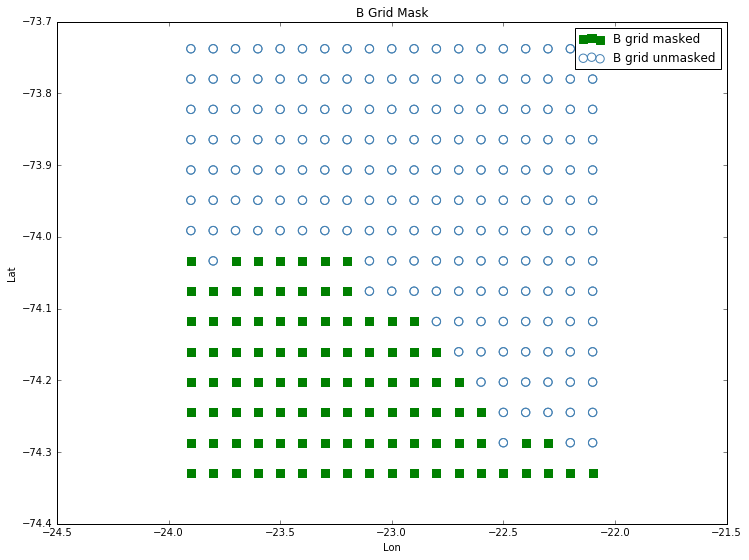

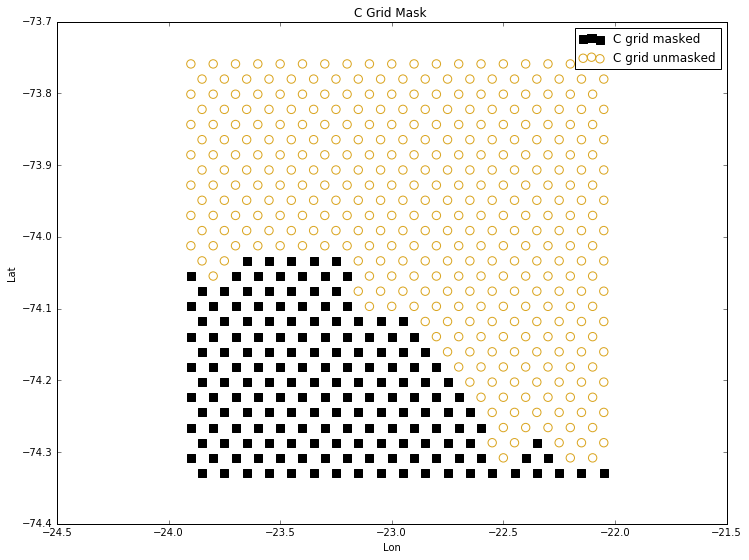

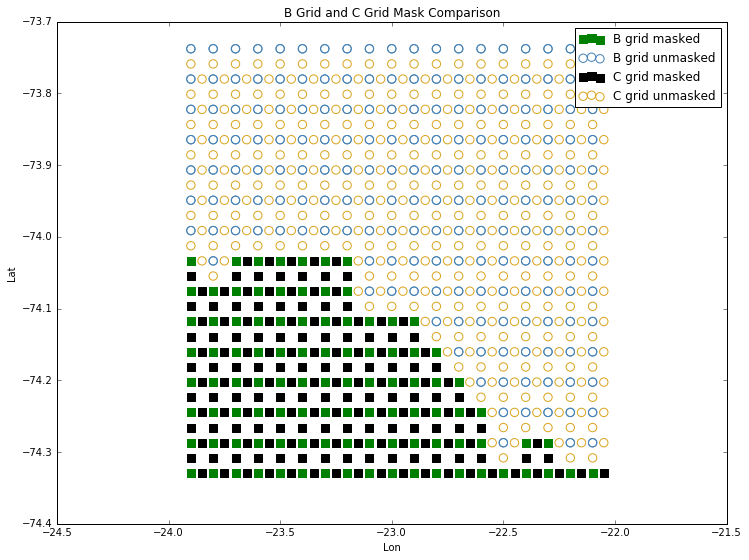

In [18]:
x_L = 2560
x_H = 2580
y_L = 160
y_H = 175
plot_masks(x_L,x_H,y_L,y_H)

### Example Region 2 

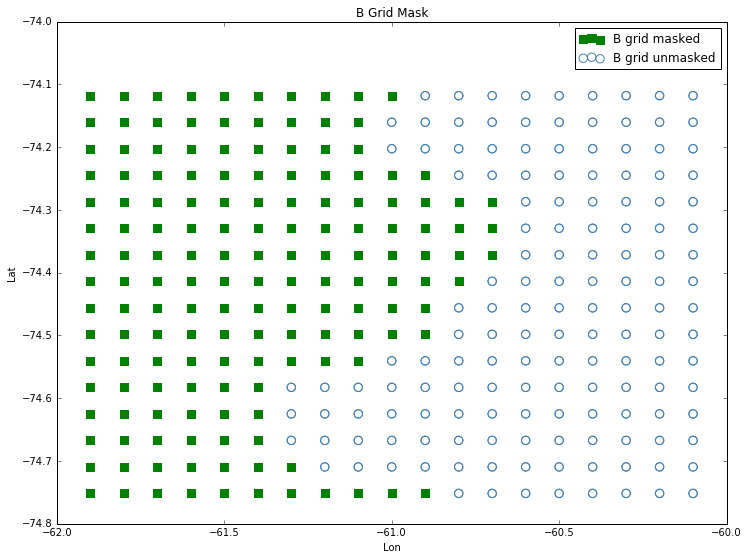

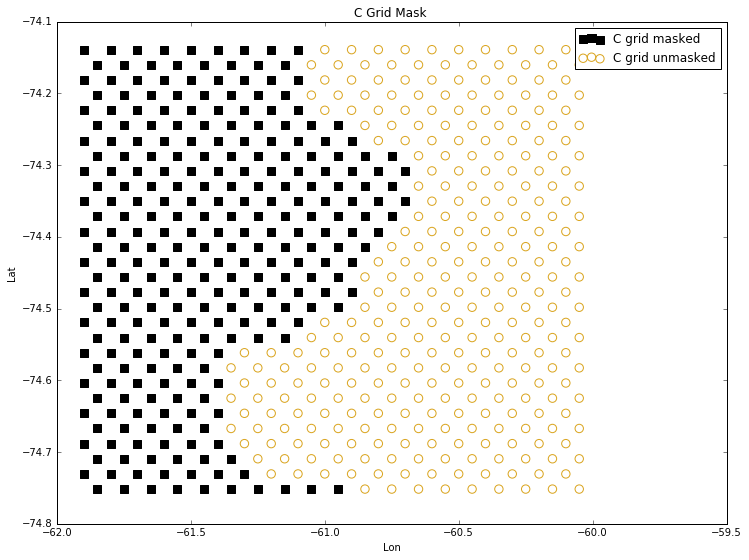

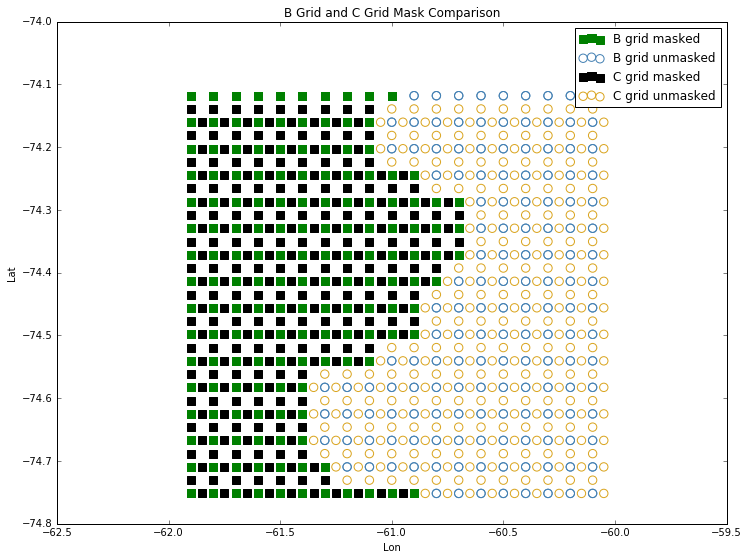

In [19]:
x_L = 2180
x_H = 2200
y_L = 150
y_H = 166
plot_masks(x_L,x_H,y_L,y_H)